# Creating a new model in eWaterCycle

If you are creating a new model, this is quite straightforward to do from within eWaterCycle.

Here we will be creating a new model, the "leaky bucket"

![diagram.png](diagram.png)

In every time step  the leaky bucket model:
- Adds the precipitation to the total storage
- Calculates the discharge: `storage * leakiness`
- Subtracts the discharge from the storage

## Preparation
First we need some simple utility functions to read the configuration and forcing (**until defaults are available**)

In [4]:
import numpy as np
import xarray as xr
from pathlib import Path
import json
from typing import Any
from lb_utils import BmiEverythingOptional

def read_config(config_file: str) -> dict:
    with open(config_file) as cfg:
        config = json.load(cfg)
    return config


def load_precip(forcing_file: str) -> xr.DataArray:
    forcing_data = xr.open_dataset(forcing_file)
    assert "time" in forcing_data.dims
    assert "precipitation" in forcing_data.data_vars
    return forcing_data["precipitation"]


def load_area(forcing_file: str) -> np.ndarray:
    forcing_data = xr.open_dataset(forcing_file)
    return forcing_data["area"].to_numpy()


## Model BMI

eWaterCycle makes use of the [Basic Model Interface](https://csdms.colorado.edu/wiki/BMI).

This is a standardized interface that is the same no matter which model you use.

Here we implement a few steps:
- Model initialization `bmi.initialize(...)`. This loads the configuration and intializes the model states.
- The model update function `bmi.update(...)`. This advances the model by one timestep and performs the hydrological calulations (adding precip. to storage, calculating discharge).
- `bmi.update_until(...)` calls `update` until a certain time step has been reached.
- `bmi.get_value(...)` is required to request a value from the model, such as the current discharge.
- `bmi.set_value(...)` is required to change a value in the model, such as the current storage.

In [5]:
class LeakyBucketLumpedBmi(BmiEverythingOptional):
    """Demonstration of a minimal hydrological model.
    
    🌧️
    🪣
    💧
    """

    def initialize(self, config_file: str) -> None:
        # The model config contains the input precipitation, and the model parameters.
        self.config: dict[str, Any] = read_config(config_file)

        # Get the input data:
        self.precipitation = load_precip(self.config["forcing_file"])
        self.area = load_area(self.config["forcing_file"])

        # Define the model states:
        n_lumps = self.precipitation.isel(time=0).size
        self.storage = np.zeros(n_lumps)
        self.discharge = np.zeros(n_lumps)

        # Define the start and end time(steps)
        self.current_time = 0
        self.end_time = self.precipitation["time"].size

        # The one model parameter is the 'leakiness' of the buckets:
        self.leakiness = self.config["leakiness"]

    def update(self) -> None:
        if self.current_time < self.end_time:
            # Add the current timestep's precipitation to the storage
            self.storage += self.precipitation.isel(time=self.current_time).to_numpy()
            
            # Calculate the discharge [m/hr] based on the leakiness and current storage
            discharge_m_per_hr = self.storage * self.leakiness
            # Subtract this discharge from the storage
            self.storage -= discharge_m_per_hr

            # Convert the discharge to [m3/s]
            self.discharge = discharge_m_per_hr * self.area / 3600

            # Advance the model time by one step
            self.current_time += 1

    def update_until(self, time: int) -> None:
        while self.current_time < time:
            self.update()

    def finalize(self) -> None:
        """There is nothing to finalize."""
        pass

    def get_value(self, var_name) -> np.ndarray:
        match var_name:
            case "storage":
                return self.storage
            case "discharge":
                return self.discharge
            case _:
                raise ValueError(f"Unknown variable {var_name}")
    
    def set_value(self, var_name, src) -> None:
        match var_name:
            case "storage":
                self.storage = src
            case _:
                raise ValueError(f"Cannot set value of var {var_name}")
    

## Testing out the BMI
With the model BMI implemented, we can now use this as our model.

Let's initialize it:

In [12]:
model = LeakyBucketLumpedBmi()
model.initialize(config_file="/home/bart/git/ewatercycle/leaky_bucket/leaky_bucket_config.json")

To be able to create a hydrograph, we need the discharge at every time step.
We can request this, put it in an array, and ask the model to advance to the next timestep:

In [9]:
discharge = np.zeros(model.end_time)
for time in range(model.end_time):
    model.update()
    discharge[time] = model.get_value("discharge")

This discharge can be shown in a plot:

Text(0.5, 0, 'Timestap (hours)')

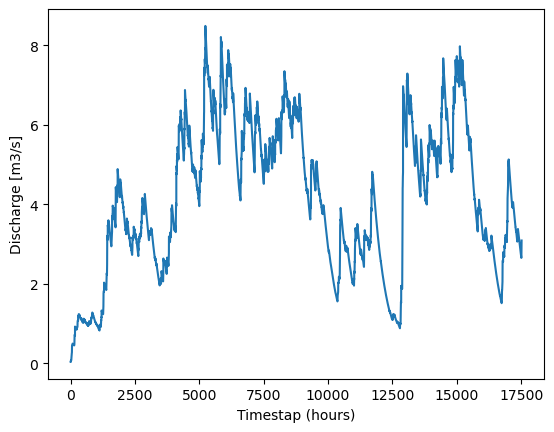

In [14]:
import matplotlib.pyplot as plt
plt.plot(discharge)
plt.ylabel("Discharge [m3/s]")
plt.xlabel("Timestap (hours)")

## Pluggin the BMI model into eWaterCycle

With the model BMI developed, we can add it to eWaterCycle. 

We start with the `LocalModel`, as this is only consists of pluggin the model into the eWaterCycle interface. Most eWaterCycle models run in a docker container, where local communication is not possible. For that the `ContainerizedModel` is used.

To add the BMI enabled model, we just need to state what the BMI class is, the forcing type, and the configuration.

To be able to modify the `leakiness` parameter, we create the `_make_cfg_file` method.

In [11]:
from ewatercycle.base.model import LocalModel
from ewatercycle.base.forcing import DefaultForcing
from pydantic import model_validator


class LeakyBucket(LocalModel):
    bmi_class = LeakyBucketLumpedBmi
    
    forcing: DefaultForcing  # not optional for this model

    _config: dict = {
        "forcing_file": "",
        "leakiness": 0.002,
    }

    @model_validator(mode="after")
    def _update_config(self: "LeakyBucket") -> "LeakyBucket":
        assert self.forcing.directory is not None
        self._config["forcing_file"] = str(self.forcing.directory / "precip.nc")
        return self
    
    def _make_cfg_file(self, **kwargs) -> Path:
        """Write model configuration file."""
        if "leakiness" in kwargs:
            self._config["leakiness"] = kwargs["leakiness"]

        config_file = self._cfg_dir / "leakybucket_config.json"

        with config_file.open() as f:
            f.write(json.dumps(self._config, indent=4))

        return config_file



/home/bart/micromamba/envs/ewatercycle310/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


### Now the model should be able to run in eWaterCycle!*
#### *Once default forcing etc. is implemented 🙃